In [1]:
%run "../head.py"

In [2]:
scAB_3d = {
    "Sperm" : h.ddir / "Sperm.scAB.20k.h5",
    "Sperm_hg" : h.ddir / "Sperm_hg.scAB.20k.h5",
}

In [3]:
from tqdm import tqdm

In [26]:
import pandas as pd
from typing import Dict, List

def hdfstore_columns(file_name: str) -> Dict[str, List[str]]:
    """
    Get the column names of all tables in an HDFStore file.

    Input:
        file_name (str): The path to the HDFStore (.h5) file.

    Output:
        A dictionary with table names as keys and lists of column names as values.
        If an error occurs while reading a table, the error message is returned as the value.
    """
    columns_dict = {}

    # Open HDFStore file and manage resource with `with` statement
    with pd.HDFStore(file_name) as store:
        # Get all table names in the HDFStore
        table_names = store.keys()

        # Check the column names for each table, read only the first few rows to save memory
        for table in table_names:
            try:
                # Read the first 5 rows
                df = pd.read_hdf(store, table, start=0, stop=5)
                columns = df.columns.tolist()  # Get column names as a list
                columns_dict[table] = columns
            except Exception as e:
                columns_dict[table] = f"Error: {e}"

    return columns_dict
def mean_scAB(h5_file, chunksize=1000000):
    with pd.HDFStore(h5_file, mode='r') as store:
        total_rows = store.get_storer("main").nrows
        total_chunks = store.get_storer("main").nrows // chunksize + 1
        for i, chunk in enumerate(tqdm(store.select(
            "main",
            iterator=True,
            chunksize=chunksize,
            ),desc="Chunkwise sum", total=total_chunks)):
            if i == 0:
                scAB_df = chunk.groupby(
                    ["chrom","start"])["scAB"].agg(["sum","size"]
                    )
            else:
                scAB_df = scAB_df.add(
                    chunk.groupby(["chrom","start"])["scAB"].agg(["sum","size"]),
                    fill_value=0
                    )
    return (scAB_df["sum"] / scAB_df["size"]).rename("scAB")
def region_scAB(h5_file, region):
    with pd.HDFStore(h5_file, mode="r") as store:
        df = store.select(
            "main",
            where = 'chrom == region[0] & start >= region[1] & start <= region[2]',
            columns = ["chrom","start","sample_name","scAB"]
        )
    df = df.set_index(["start","sample_name"])["scAB"].unstack().T
    return df
#mean_scAB(scAB_3d["Sperm"], 1000000)

In [8]:
hdfstore_columns(scAB_3d["Sperm"])

{'/main': ['chrom', 'start', 'scAB', 'sample_name']}

In [30]:
Sperm_mean_scAB = mean_scAB(scAB_3d["Sperm"], 1000000)

Chunkwise sum: 100%|██████████| 88/88 [02:27<00:00,  1.68s/it]


In [33]:
Sperm_mean_scAB.reset_index().to_parquet(h.ddir / "Sperm.mean_3d_scAB.parquet")

In [35]:
Sperm_hg_mean_scAB = mean_scAB(scAB_3d["Sperm_hg"], 1000000)

Chunkwise sum: 100%|██████████| 139/139 [03:55<00:00,  1.70s/it]


In [36]:
Sperm_hg_mean_scAB.reset_index().to_parquet(h.ddir / "Sperm_hg.mean_3d_scAB.parquet")

### show human Hoxa region

mean scAB

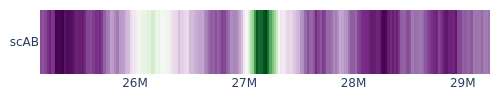

In [66]:
Sperm_hg_mean_scAB = pd.read_parquet(
    h.ddir / "Sperm_hg.mean_3d_scAB.parquet",
    )
Sperm_hg_mean_scAB = Sperm_hg_mean_scAB.set_index(["chrom","start"])

# 1*nbins
data = Sperm_hg_mean_scAB.loc[
    ("chr7", 25132560) : ("chr7", 29247100)
].droplevel(0).T

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z = data.values,
        x = data.columns,
        y = data.index,
        showscale = False,
        #zmin=0.005,
        #zmax=0.02,
        colorscale = "prgn",
    )
)
fig.update_layout(
    margin = dict(l=10, r=10, t=10, b=10),
    height = 100,
    width = 500,
)
fig.show(renderer="png")

N agg scAB

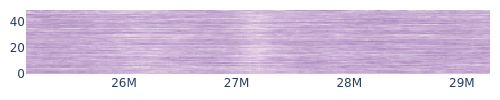

In [77]:
df = region_scAB(scAB_3d["Sperm_hg"], ("chr7", 25132560, 29247100))

m = 20

labels = np.arange(df.shape[0]) // m
grouper = pd.Series(labels, index=df.index)

data = df.groupby(grouper).mean()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z = data.values,
        x = data.columns,
        y = data.index,
        showscale = False,
        zmin=0.005,
        zmax=0.02,
        colorscale = "prgn",
    )
)
fig.update_layout(
    margin = dict(l=10, r=10, t=10, b=10),
    height = 100,
    width = 500,
)
fig.show(renderer="png")

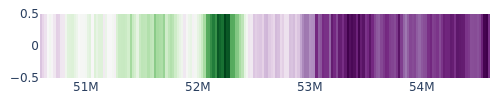

In [81]:
df = region_scAB(scAB_3d["Sperm"], ("chr6", 50600000, 54600000))

m = 1000

labels = np.arange(df.shape[0]) // m
grouper = pd.Series(labels, index=df.index)

data = df.groupby(grouper).mean()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z = data.values,
        x = data.columns,
        y = data.index,
        showscale = False,
        #zmin=0.005,
        #zmax=0.02,
        colorscale = "prgn",
    )
)
fig.update_layout(
    margin = dict(l=10, r=10, t=10, b=10),
    height = 100,
    width = 500,
)
fig.show(renderer="png")